In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from scipy.stats import norm


### Generating all Samples as per paper and my interpretation

In [2]:
np.random.seed(42)  # for reproducibility

# ==============================
# 1. Global Settings
# ==============================
N_data = (10**5)    # number of data "signal" events
N_sim  = N_data    # number of simulation events
dummyval = -10.0  # placeholder for missing entries

# Efficiency/fake parameters for data
eff_truth_data = 0.9   # fraction that keeps truth (10% missing truth)
eff_meas_data  = 0.9   # fraction that keeps measurement (10% missing measurement)
back_rate_data = 0.10   # 10% background noise for data

# Efficiency/fake parameters for simulation
eff_truth_sim = 0.9
eff_meas_sim  = 0.9


# ==============================
# 2. Generate DATA Sample
#    X_T ~ N(0.2, 0.8)  (std dev=0.8)
#    Z ~ N(0, 0.5)      (std dev=0.5)
#    X_D = X_T + Z
# ==============================

# 2a) Full truth: X_T_data_full (no missing)
X_T_data_full = np.random.normal(loc=0.2, scale=0.8, size=N_data)

# 2b) Full measurement: X_D_data_full = X_T_data_full + Z
Z_data_full = np.random.normal(loc=0.0, scale=0.5, size=N_data)
X_D_data_full = X_T_data_full + Z_data_full

# 2c) Efficiency-limited arrays: X_T_data_eff, X_D_data_eff
#     We'll copy from the full arrays and apply missing logic.
X_T_data_eff = X_T_data_full.copy()
X_D_data_eff = X_D_data_full.copy()

# Missing truth in data (10% if eff_truth_data=0.9)
is_missing_truth_data = (np.random.rand(N_data) > eff_truth_data)
X_T_data_eff[is_missing_truth_data] = dummyval

# Missing measurement in data (10% if eff_meas_data=0.9)
is_missing_meas_data = (np.random.rand(N_data) > eff_meas_data)
X_D_data_eff[is_missing_meas_data] = dummyval


# ==============================
# 3. Generate NOISE (Background) Sample
#    xN ~ N(0, 1.2), with size = back_rate_data * N_data
# ==============================
N_noise_data = int(back_rate_data * N_data)
xN_data = np.random.normal(loc=0.0, scale=1.2, size=N_noise_data)

mask_data_eff = (X_D_data_eff != dummyval)
signal_data_only   = X_D_data_eff[mask_data_eff]            # data-only signal
data_full          = np.concatenate([signal_data_only, xN_data])  # data + noise

# ==============================
# 4. Generate SIMULATION Sample
#    X_G ~ N(0,1)
#    X_S = X_G + Z,  Z ~ N(0,0.5)
# ==============================

# 4a) Full generator-level: X_G_sim_full
X_G_sim_full = np.random.normal(loc=0.0, scale=1.0, size=N_sim)

# 4b) Full detector-level: X_S_sim_full = X_G_sim_full + Z_sim
Z_sim_full = np.random.normal(loc=0.0, scale=0.5, size=N_sim)
X_S_sim_full = X_G_sim_full + Z_sim_full

# 4c) Efficiency-limited arrays: X_G_sim_eff, X_S_sim_eff
X_G_sim_eff = X_G_sim_full.copy()
X_S_sim_eff = X_S_sim_full.copy()

# Missing truth in sim
is_missing_truth_sim = (np.random.rand(N_sim) > eff_truth_sim)
X_G_sim_eff[is_missing_truth_sim] = dummyval

# Missing measurement in sim
is_missing_meas_sim = (np.random.rand(N_sim) > eff_meas_sim)
X_S_sim_eff[is_missing_meas_sim] = dummyval

# We can store them as pairs if desired:
x_synth_full = np.column_stack([X_G_sim_full, X_S_sim_full])
x_synth_  = np.column_stack([X_G_sim_eff,  X_S_sim_eff])

### Make Some Plots

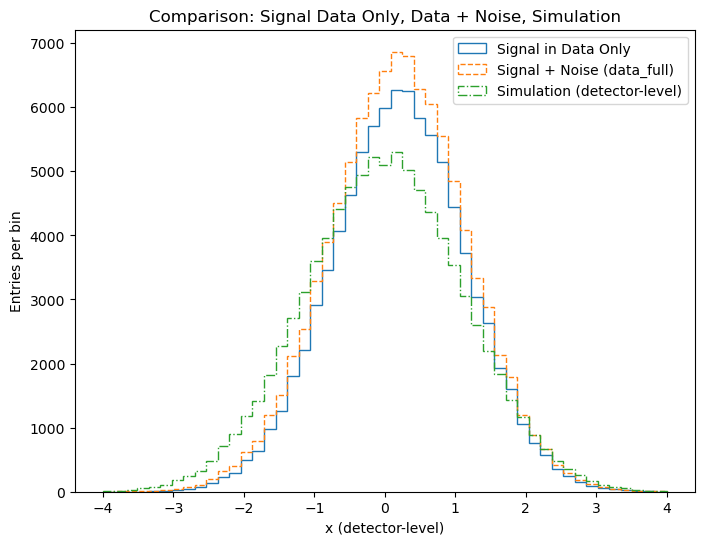

In [3]:
# 1) Mask out dummy entries
mask_sim_eff  = (X_S_sim_eff  != dummyval)

# 2) Define arrays for plotting
simulation_signal  = X_S_sim_eff[mask_sim_eff]              # detector-level simulation

# 3) Define bin edges
bins = np.linspace(-4, 4, 50)

# 4) Plot unfilled ("step") histograms, unnormalized
plt.figure(figsize=(8, 6))

plt.hist(signal_data_only, bins=bins, density=False,
         histtype='step', linestyle='-',  label="Signal in Data Only")
plt.hist(data_full,        bins=bins, density=False,
         histtype='step', linestyle='--', label="Signal + Noise (data_full)")
plt.hist(simulation_signal,bins=bins, density=False,
         histtype='step', linestyle='-.', label="Simulation (detector-level)")

plt.xlabel("x (detector-level)")
plt.ylabel("Entries per bin")  # unnormalized counts
plt.title("Comparison: Signal Data Only, Data + Noise, Simulation")
plt.legend()

### Remove background from data_full

In [4]:
x_data_and_MCback = np.concatenate([xN_data,
                                    data_full,
                                    data_full])

y_data_and_MCback = np.concatenate([np.ones(len(xN_data)),
                                    np.ones(len(data_full)),
                                    np.zeros(len(data_full))])

W_data_and_MCback = np.concatenate([-1.*np.ones(len(xN_data)),
                                    np.ones(len(data_full)),
                                    np.ones(len(data_full))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

#I did not optimize this network at all; it should probably be quite good for simple problems.  Could also swap out with a BDT for low-dimensional/tabular data.
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model1 = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    
model1.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'],
              weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
model1.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=0)
    

2025-02-13 00:28:19.969171: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping


### Predictions

In [5]:
f = model1.predict(data_full)
w_data = f/(1-f)

3127/3127 [==============================] - 1s 207us/step


### Compare data with new weights to signal only in data

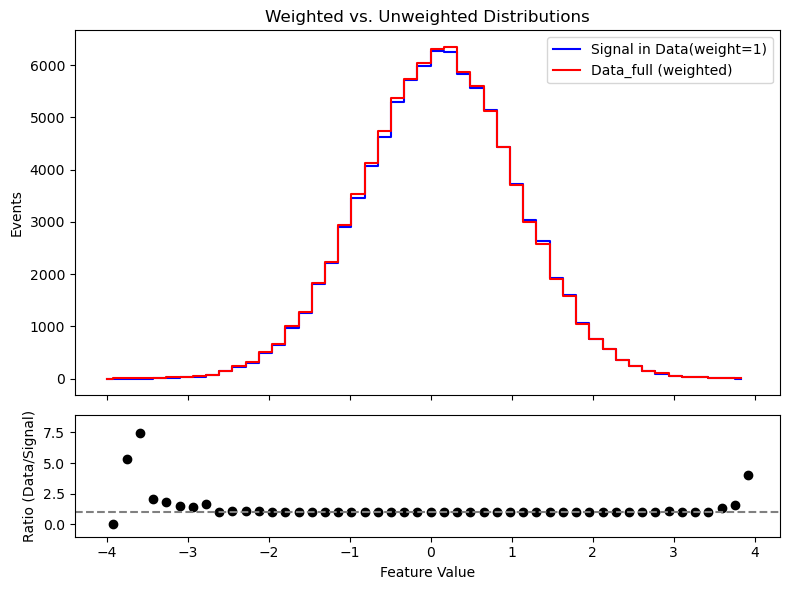

In [6]:
# Define binning
bins = np.linspace(-4, 4, 50)

# Ensure weights have the correct shape
w_data = w_data.flatten()

# Compute histograms
hist_signal, bin_edges = np.histogram(signal_data_only, bins=bins, weights=np.ones_like(signal_data_only))
hist_data, _ = np.histogram(data_full, bins=bins, weights=w_data)

# Create figure with two subplots
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(8, 6))

# Plot step histograms
ax[0].step(bin_edges[:-1], hist_signal, where="mid", label='Signal in Data(weight=1)', color='blue', linewidth=1.5)
ax[0].step(bin_edges[:-1], hist_data, where="mid", label='Data_full (weighted)', color='red', linewidth=1.5)

ax[0].legend()
ax[0].set_ylabel("Events")
ax[0].set_title("Weighted vs. Unweighted Distributions")

# Compute ratio (handling division by zero)
ratio = np.divide(hist_data, hist_signal, out=np.zeros_like(hist_data, dtype=float), where=hist_signal > 0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Plot ratio
ax[1].plot(bin_centers, ratio, marker='o', linestyle='none', color='black')
ax[1].axhline(1, linestyle='dashed', color='gray')  # Reference line at y=1
ax[1].set_ylabel("Ratio (Data/Signal)")
ax[1].set_xlabel("Feature Value")
ax[1].set_ylim(-1, max(1.2, np.nanmax(ratio) * 1.2))  # Adjust y-limit for better visibility

# Show plot
plt.tight_layout()

### Tried Optimizing the network and it does perform slightly better at the tails,not much difference though

In [7]:
# # Split dataset into training and testing sets
# X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
#     x_data_and_MCback, y_data_and_MCback, W_data_and_MCback, test_size=0.2, random_state=42
# )

# # Ensure w_train_1 and w_test_1 have the correct shape
# w_train_1 = w_train_1.flatten()
# w_test_1 = w_test_1.flatten()

# # Define the model
# inputs = Input((1,))

# # First hidden layer
# hidden_layer_1 = Dense(100, kernel_regularizer=l2(1e-4))(inputs)
# hidden_layer_1 = LeakyReLU(alpha=0.1)(hidden_layer_1)  # Using LeakyReLU
# hidden_layer_1 = BatchNormalization()(hidden_layer_1)
# hidden_layer_1 = Dropout(0.2)(hidden_layer_1)

# # Second hidden layer
# hidden_layer_2 = Dense(100, kernel_regularizer=l2(1e-4))(hidden_layer_1)
# hidden_layer_2 = LeakyReLU(alpha=0.1)(hidden_layer_2)
# hidden_layer_2 = BatchNormalization()(hidden_layer_2)
# hidden_layer_2 = Dropout(0.2)(hidden_layer_2)

# # Third hidden layer
# hidden_layer_3 = Dense(50, kernel_regularizer=l2(1e-4))(hidden_layer_2)
# hidden_layer_3 = LeakyReLU(alpha=0.1)(hidden_layer_3)
# hidden_layer_3 = BatchNormalization()(hidden_layer_3)
# hidden_layer_3 = Dropout(0.2)(hidden_layer_3)

# # Output layer
# outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

# # Define model
# model2 = Model(inputs=inputs, outputs=outputs)

# # Optimizer with a tuned learning rate
# optimizer = Adam(learning_rate=0.001)

# # Early stopping callback
# earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# # Learning rate reduction callback
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# # Compile model
# model2.compile(loss='binary_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'],
#               weighted_metrics=[])

# # Train model
# model2.fit(X_train_1,
#           Y_train_1,
#           sample_weight=w_train_1,
#           epochs=300,  # More epochs for better learning
#           batch_size=512,  # Optimized batch size
#           validation_data=(X_test_1, Y_test_1, w_test_1),
#           callbacks=[earlystopping, reduce_lr],  # Optimized callbacks
#           verbose=0)


In [8]:
# f = model2.predict(data_full)
# w_data = f/(1-f)

In [9]:
# # Define binning
# bins = np.linspace(-4, 4, 50)

# # Ensure weights have the correct shape
# w_data = w_data.flatten()

# # Compute histograms
# hist_signal, bin_edges = np.histogram(signal_data_only, bins=bins, weights=np.ones_like(signal_data_only))
# hist_data, _ = np.histogram(data_full, bins=bins, weights=w_data)

# # Create figure with two subplots
# fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(8, 6))

# # Plot step histograms
# ax[0].step(bin_edges[:-1], hist_signal, where="mid", label='Signal in Data(weight=1)', color='blue', linewidth=1.5)
# ax[0].step(bin_edges[:-1], hist_data, where="mid", label='Data (weighted)', color='red', linewidth=1.5)

# ax[0].legend()
# ax[0].set_ylabel("Events")
# ax[0].set_title("Weighted vs. Unweighted Distributions")

# # Compute ratio (handling division by zero)
# ratio = np.divide(hist_data, hist_signal, out=np.zeros_like(hist_data, dtype=float), where=hist_signal > 0)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# # Plot ratio
# ax[1].plot(bin_centers, ratio, marker='o', linestyle='none', color='black')
# ax[1].axhline(1, linestyle='dashed', color='gray')  # Reference line at y=1
# ax[1].set_ylabel("Ratio (Data/Signal)")
# ax[1].set_xlabel("Feature Value")
# ax[1].set_ylim(-1, max(1.2, np.nanmax(ratio) * 1.2))  # Adjust y-limit for better visibility

# # Show plot
# plt.tight_layout()

### Now we will handle migration effects + efficiency + fakes 

We are following the algorithm in https://arxiv.org/pdf/2105.04448, inculding variable names and all conventions

In [10]:
def build_model():
    inputs = Input((1, ))  # Input layer with 1 feature
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)  # Sigmoid for binary classification

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# N_iterations = 3

# # data_full, X_G_sim_eff, X_S_sim_eff
# # w_data, w_synth = ones
# # we will use model1 architecture for simplicity

# w_synth = np.ones(len(X_G_sim_eff))

# for k in range(N_iterations):

#     ###### step (a) ######

#     x_data_and_MC = np.concatenate([data_full, X_S_sim_eff[X_S_sim_eff != dummyval]])
#     y_data_and_MC = np.concatenate([np.ones(len(data_full)), np.zeros(len(X_S_sim_eff[X_S_sim_eff != dummyval]))])
#     w_data_and_MC = np.concatenate([w_data, w_synth[X_S_sim_eff != dummyval]])

#     X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_data_and_MC, y_data_and_MC, w_data_and_MC)

#     model1 = build_model()

#     model1.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'],
#               weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
    
#     model1.fit(X_train,
#           Y_train,
#           sample_weight=w_train,
#           epochs=200,
#           batch_size=10000,
#           validation_data=(X_test, Y_test, w_test),
#           callbacks=[earlystopping],
#           verbose=0)
    
#     f = model1.predict(X_S_sim_eff)
#     wstep1 = w_synth*(f/(1-f))

#     ###### step (b) ######
    
#     # only train the model

#     x_gen_eff_and_gen_eff = np.concatenate([X_G_sim_eff[X_S_sim_eff != dummyval] , X_G_sim_eff[X_S_sim_eff != dummyval]])
#     y_gen_eff_and_gen_eff = np.concatenate([np.ones(len(X_G_sim_eff[X_S_sim_eff != dummyval])), np.zeros(len(X_G_sim_eff[X_S_sim_eff != dummyval]))])
#     w_gen_eff_and_gen_eff = np.concatenate([wstep1[X_S_sim_eff != dummyval], np.ones(len(X_G_sim_eff[X_S_sim_eff != dummyval]))])

#     X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_gen_eff_and_gen_eff, y_gen_eff_and_gen_eff, w_gen_eff_and_gen_eff)

#     model1 = build_model()

#     model1.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'],
#               weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
    
#     model1.fit(X_train,
#           Y_train,
#           sample_weight=w_train,
#           epochs=200,
#           batch_size=10000,
#           validation_data=(X_test, Y_test, w_test),
#           callbacks=[earlystopping],
#           verbose=0)
    
#     ###### step (c) ######

#     f = model1.predict(X_G_sim_eff)
#     wPull = np.where(X_S_sim_eff != dummyval, wstep1, w_synth*(f / (1 - f)))

#     ###### step (d) ######

#     x_gen_and_gen = np.concatenate([X_G_sim_eff, X_G_sim_eff])
#     y_gen_and_gen = np.concatenate([np.ones(len(X_G_sim_eff)), np.zeros(len(X_G_sim_eff))])
#     w_gen_and_gen = np.concatenate([wPull, w_synth])
    
#     X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_gen_and_gen, y_gen_and_gen, w_gen_and_gen)

#     model1 = build_model()

#     model1.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'],
#               weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
    
#     model1.fit(X_train,
#           Y_train,
#           sample_weight=w_train,
#           epochs=200,
#           batch_size=10000,
#           validation_data=(X_test, Y_test, w_test),
#           callbacks=[earlystopping],
#           verbose=0)

#     f = model1.predict(X_G_sim_eff)
#     wstep2 = w_synth*(f/(1-f))

#     ###### step (e) ######

#     x_sim_eff_and_sim_eff = np.concatenate([X_S_sim_eff[X_G_sim_eff != dummyval], X_S_sim_eff[X_G_sim_eff != dummyval]])
#     y_sim_eff_and_sim_eff = np.concatenate([np.ones(len(X_S_sim_eff[X_G_sim_eff != dummyval])), np.zeros(len(X_S_sim_eff[X_G_sim_eff != dummyval]))])
#     w_sim_eff_and_sim_eff = np.concatenate([wstep2[X_G_sim_eff != dummyval], np.ones(len(X_S_sim_eff[X_G_sim_eff != dummyval]))])

#     X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_sim_eff_and_sim_eff, y_sim_eff_and_sim_eff, w_sim_eff_and_sim_eff)

#     model1 = build_model()

#     model1.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'],
#               weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
    
#     model1.fit(X_train,
#           Y_train,
#           sample_weight=w_train,
#           epochs=200,
#           batch_size=10000,
#           validation_data=(X_test, Y_test, w_test),
#           callbacks=[earlystopping],
#           verbose=0)
    
#     ###### step (f) ######

#     f = model1.predict(X_S_sim_eff)
#     wPush = np.where(X_G_sim_eff != dummyval, wstep2, w_synth*(f / (1 - f)))

#     ###### step (g) ######

#     w_synth = wPush


: 

In [ ]:
N_iterations = 3

# data_full, X_G_sim_eff, X_S_sim_eff
# w_data, w_synth = ones

# Early stopping configuration
earlystopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

# Initialize synthetic weights
w_synth = np.ones(len(X_G_sim_eff))

# Precompute valid indices for filtering `dummyval`
valid_XS_mask = X_S_sim_eff != dummyval  # Boolean mask
valid_XG_mask = X_G_sim_eff != dummyval  # Boolean mask

for k in range(N_iterations):

    ###### Step (a) ######
    valid_XS_indices = np.where(valid_XS_mask)[0]  # Faster indexing
    x_data_and_MC = np.concatenate([data_full, X_S_sim_eff[valid_XS_indices]])
    y_data_and_MC = np.concatenate([np.ones(len(data_full)), np.zeros(len(valid_XS_indices))])
    w_data_and_MC = np.concatenate([w_data, w_synth[valid_XS_indices]])

    X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_data_and_MC, y_data_and_MC, w_data_and_MC)

    model1 = build_model()
    model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'], weighted_metrics=[])
    model1.fit(X_train, Y_train, sample_weight=w_train, epochs=200, batch_size=10000, 
               validation_data=(X_test, Y_test, w_test), callbacks=[earlystopping], verbose=0)

    f_XS = model1.predict(X_S_sim_eff, batch_size=10000)  # Faster prediction
    wstep1 = w_synth * (f_XS / (1 - f_XS))

    ###### Step (b) ######
    valid_XG_indices = np.where(valid_XG_mask)[0]  # Faster indexing
    x_gen_eff_and_gen_eff = np.concatenate([X_G_sim_eff[valid_XS_indices], X_G_sim_eff[valid_XS_indices]])
    y_gen_eff_and_gen_eff = np.concatenate([np.ones(len(valid_XS_indices)), np.zeros(len(valid_XS_indices))])
    w_gen_eff_and_gen_eff = np.concatenate([wstep1[valid_XS_indices], np.ones(len(valid_XS_indices))])

    X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_gen_eff_and_gen_eff, y_gen_eff_and_gen_eff, w_gen_eff_and_gen_eff)

    model1 = build_model()
    model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'], weighted_metrics=[])
    model1.fit(X_train, Y_train, sample_weight=w_train, epochs=200, batch_size=10000, 
               validation_data=(X_test, Y_test, w_test), callbacks=[earlystopping], verbose=0)

    ###### Step (c) ######
    f_XG = model1.predict(X_G_sim_eff, batch_size=10000)
    wPull = np.where(valid_XS_mask, wstep1, w_synth * (f_XG / (1 - f_XG)))

    ###### Step (d) ######
    x_gen_and_gen = np.tile(X_G_sim_eff, 2)  # Avoid duplicate indexing
    y_gen_and_gen = np.tile([1, 0], len(X_G_sim_eff))
    w_gen_and_gen = np.concatenate([wPull, w_synth])

    X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_gen_and_gen, y_gen_and_gen, w_gen_and_gen)

    model1 = build_model()
    model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'], weighted_metrics=[])
    model1.fit(X_train, Y_train, sample_weight=w_train, epochs=200, batch_size=10000, 
               validation_data=(X_test, Y_test, w_test), callbacks=[earlystopping], verbose=0)

    f_XG = model1.predict(X_G_sim_eff, batch_size=10000)
    wstep2 = w_synth * (f_XG / (1 - f_XG))

    ###### Step (e) ######
    x_sim_eff_and_sim_eff = np.concatenate([X_S_sim_eff[valid_XG_indices], X_S_sim_eff[valid_XG_indices]])
    y_sim_eff_and_sim_eff = np.tile([1, 0], len(valid_XG_indices))
    w_sim_eff_and_sim_eff = np.concatenate([wstep2[valid_XG_indices], np.ones(len(valid_XG_indices))])

    X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(x_sim_eff_and_sim_eff, y_sim_eff_and_sim_eff, w_sim_eff_and_sim_eff)

    model1 = build_model()
    model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'], weighted_metrics=[])
    model1.fit(X_train, Y_train, sample_weight=w_train, epochs=200, batch_size=10000, 
               validation_data=(X_test, Y_test, w_test), callbacks=[earlystopping], verbose=0)

    ###### Step (f) ######
    f_XS = model1.predict(X_S_sim_eff, batch_size=10000)
    wPush = np.where(valid_XG_mask, wstep2, w_synth * (f_XS / (1 - f_XS)))

    ###### Step (g) ######
    w_synth[:] = wPush  # In-place update for memory efficiency


Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
10/10 [==============================] - 0s 1ms/step


In [ ]:
final_xG = X_G_sim_eff[X_G_sim_eff != dummyval]
final_w_synth = w_synth[X_G_sim_eff != dummyval]